# Proyecto 1

## 1. Carga de librerías

In [112]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
# Importar el contador de vectorizacion e inicializarlo
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to C:\Users\María
[nltk_data]     Camila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Lectura de datos

In [113]:
df = pd.read_csv('C:/Users/María Camila/Documents/Universidad/Séptimo semestre/BI/Laboratorio/LaboratoriosBI/Proyecto1/datos.csv',sep=';',header=None)
df.columns = ['mensaje','sentimiento']
df

,mensaje,sentimiento
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


## 3. Limpieza y tokenización

In [114]:
def limpiar_tokenizar(mensaje):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = mensaje.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(mensaje=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [115]:
# Se aplica la función de limpieza y tokenización a cada mensaje
# ==============================================================================
df['mensaje_tokenizado'] = df['mensaje'].apply(lambda x: limpiar_tokenizar(x))
df[['mensaje', 'mensaje_tokenizado']].head()

,mensaje,mensaje_tokenizado
0,im feeling rather rotten so im not very ambiti...,"[im, feeling, rather, rotten, so, im, not, ver..."
1,im updating my blog because i feel shitty,"[im, updating, my, blog, because, feel, shitty]"
2,i never make her separate from me because i do...,"[never, make, her, separate, from, me, because..."
3,i left with my bouquet of red and yellow tulip...,"[left, with, my, bouquet, of, red, and, yellow..."
4,i was feeling a little vain when i did this one,"[was, feeling, little, vain, when, did, this, ..."


## 4. Análisis exploratorio

In [116]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
df_tidy = df.explode(column='mensaje_tokenizado')
df_tidy = df_tidy.drop(columns='mensaje')
df_tidy = df_tidy.rename(columns={'mensaje_tokenizado':'token'})
df_tidy.head(3)

,sentimiento,token
0,sadness,im
0,sadness,feeling
0,sadness,rather


### Palabras totales utilizadas

In [117]:
df_tidy['token'].count()

34073

### Palabras totales distintas

In [118]:
df_tidy['token'].nunique()

4778

### Palabras más utilizadas

In [119]:
 # df_tidy.groupby(['token'])["token"] \
 # .count() \
 # .reset_index(name='count') \
 # .apply(lambda x: x.sort_values('count', ascending=False).head(5))

## 5. Stop words

In [120]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [121]:
# Filtrado para excluir stopwords
# ==============================================================================
df_tidy = df_tidy[~(df_tidy["token"].isin(stop_words))]

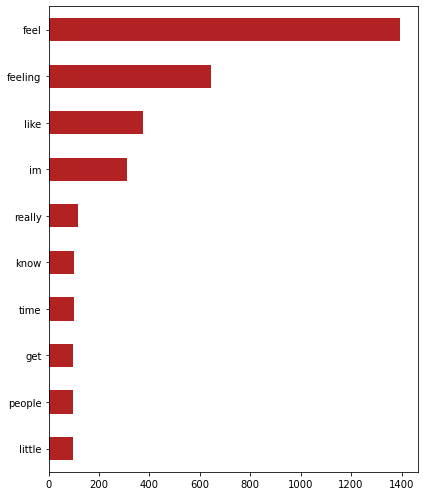

In [122]:
# Top 10 palabras (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(6, 7))
counts  = df_tidy['token'].value_counts(ascending=False).head(10)
counts.plot(kind='barh', color='firebrick')
axs.invert_yaxis()
fig.tight_layout()

## 6. Team frequency

In [123]:
# Cálculo term-frecuency (tf)
# ==============================================================================
tf = df_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('token')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,token,count,total_count,tf
0,aaaah,1,1,1.0
3099,powers,1,1,1.0
3098,powerless,1,1,1.0


In [124]:
# Inverse document frequency
# ==============================================================================
idf = df_tidy.copy()
total_documents = idf["token"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
1515,feel,1394,1.203399
1516,feeling,646,1.972532
2371,like,373,2.521753


## 7. Train test

In [125]:
#Reparto train y test
# ==============================================================================
datos_X = df['mensaje']
datos_y = df['sentimiento']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [126]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'anger': 13.125, 'fear': 11.1875, 'joy': 35.0, 'love': 7.875, 'sadness': 29.25, 'surprise': 3.5625}
{'anger': 16.25, 'fear': 11.25, 'joy': 33.75, 'love': 8.25, 'sadness': 28.25, 'surprise': 2.25}


In [127]:
X = df['mensaje']
y = df['sentimiento']

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.3,
                                        random_state = 123
                                    )

## 8.Vectorización

In [129]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words,
                        analyzer = "word"
                    )
X_vec = tfidf_vectorizador.fit_transform(X)
# X = pd.DataFrame(X_vec.toarray(), columns=tfidf_vectorizador.get_feature_names())
# X

In [130]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 1257
['abandoned', 'able', 'absolutely', 'accept', 'acceptable', 'accepted', 'accepting', 'aching', 'act', 'action']


In [131]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

## 8. Algoritmo Naive Baynes

In [132]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()
# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)
# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [133]:
#Se crea el modelo
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB()

In [134]:
#Se tienen las predicciones
predictions = naive_bayes.predict(testing_data)

In [135]:
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions,average='weighted')))
print('Recall score: ', format(recall_score(y_test, predictions, pos_label='positive',average='weighted')))
print('F1 score: ', format(f1_score(y_test, predictions, pos_label='positive',average='weighted')))

Accuracy score:  0.45714285714285713
Precision score:  0.4932016229727714
Recall score:  0.45714285714285713
F1 score:  0.3644778812293168


In [136]:
# Se genera la matriz de confusión
confusion_matrix(y_test, predictions)

array([[ 10,   0, 145,   0,  40,   0],
       [  2,   4, 112,   0,  43,   0],
       [  0,   1, 423,   0,  41,   0],
       [  1,   0, 101,   0,  12,   0],
       [  0,   0, 214,   0, 203,   0],
       [  0,   1,  37,   0,  10,   0]], dtype=int64)

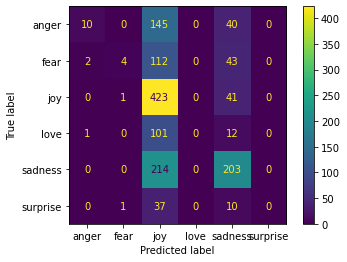

In [137]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(naive_bayes, testing_data, y_test)  
plt.show()

## 9.KNN

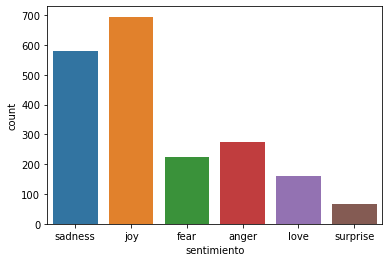

In [138]:
# print(len(X_vec.toarray()), df["sentimiento"].count())
ax = sns.countplot(x='sentimiento', data=df)

### 9.1 Primer intento 

In [139]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh = neigh.fit(tfidf_train, y_train)

In [140]:
y_pred = neigh.predict(tfidf_test)

In [141]:
# Se genera la matriz de confusión
confusion_matrix(y_test, y_pred)

array([[113,  12,  38,   6,  26,   0],
       [ 24,  74,  33,   3,  25,   2],
       [ 64,  30, 313,  13,  43,   2],
       [ 24,   5,  56,  20,   9,   0],
       [ 71,  35,  75,   2, 234,   0],
       [  7,  12,  12,   2,   7,   8]], dtype=int64)

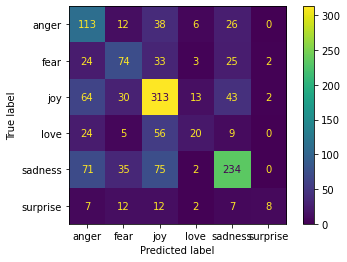

In [142]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(neigh, tfidf_test, y_test)  
plt.show()

In [144]:
# Mostrar reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.37      0.58      0.45       195
        fear       0.44      0.46      0.45       161
         joy       0.59      0.67      0.63       465
        love       0.43      0.18      0.25       114
     sadness       0.68      0.56      0.61       417
    surprise       0.67      0.17      0.27        48

    accuracy                           0.54      1400
   macro avg       0.53      0.44      0.44      1400
weighted avg       0.56      0.54      0.54      1400



### KNN mejorado

### Hiperparámetros

In [159]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

# Lista de Hiperparámetros a afinar
n_neighbors = list(range(1,10))
n_odd_neighbors = list(filter(lambda x: (x % 2 != 0), n_neighbors))
p=[1,2] #Función de distancia 1: manhattan, 2: euclidean, otro valor: minkowski

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
mejor_modelo_knn = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
mejor_modelo_knn.fit(tfidf_train, y_train)

#Print The value of best Hyperparameters
print('Best p:', mejor_modelo_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', mejor_modelo_knn.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 5


In [161]:
# Obtener el mejor modelo.
neigh_final = mejor_modelo_knn.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = neigh_final.predict(tfidf_train)
y_pred_test = neigh_final.predict(tfidf_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.75
Exactitud sobre test: 0.56


In [162]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       anger       0.46      0.47      0.47       195
        fear       0.56      0.41      0.47       161
         joy       0.55      0.77      0.65       465
        love       0.44      0.21      0.29       114
     sadness       0.64      0.58      0.61       417
    surprise       0.57      0.08      0.15        48

    accuracy                           0.56      1400
   macro avg       0.54      0.42      0.44      1400
weighted avg       0.56      0.56      0.54      1400



In [163]:
#Con los mejores vecinos

In [167]:
#Estadísticas test
neigh = KNeighborsClassifier(n_neighbors=5) # arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)
neigh = neigh.fit(tfidf_train, y_train) # arbol = arbol.fit(X_train,Y_train)
y_pred = neigh.predict(tfidf_test) # y_pred = arbol.predict(X_test)
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred, average= 'weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred, average = 'weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred, average= 'weighted')))

Exactitud: 0.56
Recall: 0.5607142857142857
Precisión: 0.5598750532458516
Puntuación F1: 0.5427532535795775


In [166]:
#Estadisticas con el conjunto de entrenamiento
y_pred = neigh.predict(tfidf_train) # y_pred = arbol.predict(X_train)
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred))
print("Recall: {}".format(recall_score(y_train,y_pred, average= 'weighted')))
print("Precisión: {}".format(precision_score(y_train,y_pred, average= 'weighted')))
print("Puntuación F1: {}".format(f1_score(y_train,y_pred, average= 'weighted')))

Exactitud: 0.75
Recall: 0.75
Precisión: 0.753650815945119
Puntuación F1: 0.7413410814809024
